# Hydrogen atom, 1D

In [1]:
import os
print("LD_LIBRARY_PATH=" + os.environ['LD_LIBRARY_PATH'])

LD_LIBRARY_PATH=/home/hideo-t/work/py/crsq/.venv/lib/python3.10/site-packages/nvidia/cusparse/lib


In [2]:
import math
import numpy as np
import scipy.special as sp

# make one dimentional wave function data for H atom.

def hydrogen1d_psi(xa: np.ndarray,x0: float,N: int):
    hbar = 1
    me = 1
    qe = 1
    a0 = 1
    a0 = hbar*hbar/(me*qe*qe)
    x = xa - x0
    absx = np.abs(x)
    A = np.sqrt(2/((a0**3)*(N**5)*math.factorial(N)**2))
    lg = sp.assoc_laguerre(2*absx/(N*a0), N-1, 1)
    psi = A*x*np.exp(-absx/(N*a0))*lg
    return psi


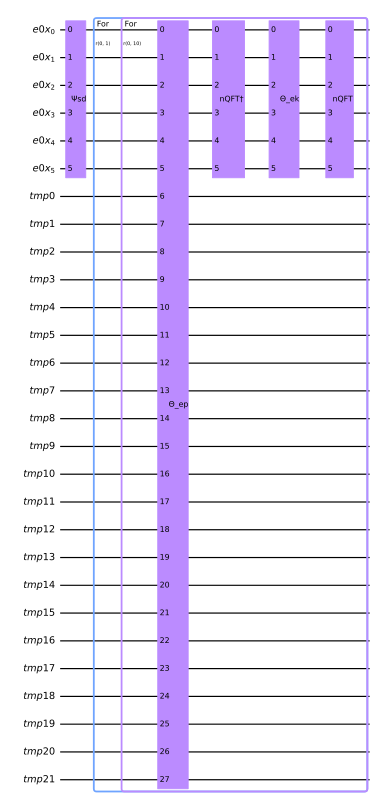

In [3]:
import math
import numpy as np

from crsq.blocks.antisymmetrization import AntisymmetrizationSpec
from crsq.blocks.discretization import DiscretizationSpec
from crsq.blocks.energy_initialization import EnergyConfigurationSpec
from crsq.blocks.hamiltonian import HamiltonianSpec
from crsq.blocks.time_evolution.spec import TimeEvolutionSpec
from crsq.blocks.wave_function import WaveFunctionRegisterSpec
from crsq.blocks.time_evolution.suzuki_trotter import SuzukiTrotterMethodBlock

dim = 1  # 1 dimension
n1 = 6 # bits per coordinate
M=1<<n1
L = 16 # 16 bohr
eta = 1 # num of electrons
Ln = 0 # moving nucleus
Ls = 1 # stationary nucleus
antisym_method = 3 # binary coded antisymmetrization method
wfr_spec = WaveFunctionRegisterSpec(dim, n1, L, eta, Ln, Ls)

delta_t = 0.001 # a.u.
disc_spec = DiscretizationSpec(delta_t)
asy_spec = AntisymmetrizationSpec(wfr_spec, antisym_method)
nuclei_data = [{"mass": 1680, "charge": 1, "pos": (M//2, M//2)}]

ham_spec = HamiltonianSpec(wfr_spec, nuclei_data=nuclei_data)


M = 2**n1
dq = L/M

x = np.linspace(0, L-dq, M)
x0 = 8
k = 4
sigma = 1
psix = hydrogen1d_psi(x, x0, N=1)
#psix = np.zeros(M)
# psiy = np.zeros(M)

# ini_dims = [psix, psiy]
ini_dims = [psix]
ini_electrons = [ini_dims]
ini_configs = [ini_electrons]
initial_electron_orbitals = ini_configs

initial_nucleus_orbitals = [[]]
ene_spec = EnergyConfigurationSpec([1], initial_electron_orbitals, initial_nucleus_orbitals)

num_nucl_it = 1 # number of nucleus iterations
num_elec_it = 10 # number of electron iterations
evo_spec = TimeEvolutionSpec(ham_spec, disc_spec, num_nucl_it, num_elec_it)

stm = SuzukiTrotterMethodBlock(evo_spec, ene_spec, asy_spec)

stm.circuit.draw(output='mpl', scale=0.6)


In [6]:
from qiskit_aer import AerSimulator
from qiskit import transpile
import crsq.utils.statevector as svec

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger('TEV')
logger.setLevel(logging.INFO)

run_calculation=True
# run_calculation=False

dirname="output/time-evolution"
basename="h1d"

#num_iters = [1, 10, 100, 500, 1000, 1500]
num_iters = [1, 10, 100]

if run_calculation:
    backend = AerSimulator(method="statevector", device="CPU", cuStateVec_enable=False, precision="single")
    for num_elec_it in num_iters:
        num_nucl_it = 1 # number of nucleus iterations
        evo_spec = TimeEvolutionSpec(ham_spec, disc_spec, num_nucl_it, num_elec_it)
        stm = SuzukiTrotterMethodBlock(evo_spec, ene_spec, asy_spec)

        circ = stm.circuit
        circ.save_statevector()
        logger.info('transpile START')
        transpiled = transpile(circ, backend)
        logger.info('transpile END, run START')
        results = backend.run(transpiled).result()
        logger.info('run END')
        sv = results.get_statevector()
        time=num_elec_it*delta_t
        fname = f"{dirname}/{basename}.{n1}b.mu{x0}t{time}.csv"
        print("Saving to : " + fname)
        svec.save_to_file(fname, sv, eps=1e-12)

        elementary_gate_counts = transpiled.count_ops()
        print(elementary_gate_counts)

INFO:TEV:transpile START
INFO:TEV:transpile END, run START
